In [ ]:
!pip install empath
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
import itertools
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
import spacy
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
import string
import re
import nltk
import collections
from nltk.corpus import stopwords
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from empath import Empath
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pickle
import scipy.sparse as sp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 57 kB 3.3 MB/s 
  Created wheel for empath: filename=empath-0.89-py3-none-any.whl size=57821 sha256=1b9007a98071ac46ec2a523c1fe4e654eb3443ab9e2aa006c373d50b1299a3d7
  Stored in directory: /root/.cache/pip/wheels/2b/78/a8/37d4505eeae79807f4b5565a193f7cfcee892137ad37591029
Successfully built empath


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
news = pd.read_csv('/content/gdrive/MyDrive/Dataset/data.csv')
news.head()

,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1
1,https://www.reuters.com/article/us-filmfestiva...,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1
2,https://www.nytimes.com/2017/10/09/us/politics...,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,1
3,https://www.reuters.com/article/us-mexico-oil-...,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",1


In [ ]:
news.loc[news['Label']== 1, 'Label'] = 'REAL'
news.loc[news['Label']== 0, 'Label'] = 'FAKE'
news['Label'].value_counts()

FAKE    2137
REAL    1872
Name: Label, dtype: int64

In [ ]:
news.drop(['URLs'], axis = 1, inplace = True)
news.head()

,Headline,Body,Label
0,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,REAL
1,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",REAL
2,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,REAL
3,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,REAL
4,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",REAL


In [ ]:
news_stats = pd.read_csv('/content/gdrive/MyDrive/Dataset/fake.csv')
news_stats.head()

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689.0,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689.0,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias


In [ ]:
news_stats['type'].value_counts()

bs            11492
bias            443
conspiracy      430
hate            246
satire          146
state           121
junksci         102
fake             19
Name: type, dtype: int64

In [ ]:
#Selecting only fake news from all the types of news and then replacing the 'fake' by
fake_news_stats = news_stats.loc[news_stats['type']=='fake']
fake_news_stats.loc[fake_news_stats['type']== 'fake', 'type'] = 'FAKE'
fake_news_stats.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
57,8a35883f9c9f0b15a9e20ab8711d403d91d57405,0,Jimmy Rustling,2016-10-27T13:00:00.000+03:00,The Amish In America Commit Their Vote To Dona...,18 SHARE The Amish in America have committed t...,english,2016-10-27T15:50:22.818+03:00,abcnews.com.co,CO,65078.0,The Amish In America Commit Their Vote To Dona...,0.000,http://abcnews.com.co/wp-content/uploads/2016/...,0,0,0,0,0,FAKE
58,c6fb8dae30e3d378935e910540a0cb99b5351ac0,0,Jimmy Rustling,2016-11-11T12:00:00.000+02:00,Obama Signs Executive Order Declaring Investig...,64 SHARE President Obama has signed an Executi...,english,2016-11-11T16:33:32.484+02:00,abcnews.com.co,US,65078.0,Obama Signs Executive Order Declaring Investig...,0.009,http://abcnews.com.co/wp-content/uploads/2016/...,0,0,0,0,0,FAKE
379,504e8fa4469d75f8d22984220568e3313c74a1b7,0,"Day of the Dead 2015: History, food and reflec...",2016-10-27T05:18:00.000+03:00,Comment on HALLOWEEN IN THE CASTRO RETURNS IN ...,"adobochron 10 Comments \nSan Francisco, Califo...",english,2016-10-27T07:25:28.782+03:00,adobochronicles.com,US,NaN,Comment on HALLOWEEN IN THE CASTRO RETURNS IN ...,0.000,https://adobochroniclesdotcom.files.wordpress....,0,1,0,0,0,FAKE
380,20e1a45f760f8db5f26207bbfe827bf8cd6d65bb,0,Ivan Jose,2016-10-27T09:18:46.193+03:00,Comment on Tutorial: Riding The Philippine Jee...,"adobochron 1 Comment \nMANILA, Philippines (Th...",english,2016-10-27T09:18:46.193+03:00,adobochronicles.com,US,NaN,Comment on Tutorial: Riding The Philippine Jee...,0.000,https://adobochroniclesdotcom.files.wordpress....,0,1,0,0,0,FAKE
381,9874fcff14d4af3c13954116c55590b28a5b98b8,0,Tony Rabon,2016-10-28T19:56:09.149+03:00,Comment on What White House Executive Chef Com...,"adobochron 1 Comment Comerford \nWASHINGTON, D...",english,2016-10-28T19:56:09.149+03:00,adobochronicles.com,US,NaN,Comment on What White House Executive Chef Com...,0.000,https://adobochroniclesdotcom.files.wordpress....,0,1,0,0,0,FAKE


In [ ]:
#Selecting some columns from the table and renaming them\n",
fake_news_stats = fake_news_stats.rename(columns={'title':'Headline','text':'Body','type':'Label'})[['Headline','Body','Label']]
fake_news_stats['Label'].value_counts()

FAKE    19
Name: Label, dtype: int64

In [ ]:
fake_or_real = pd.read_csv('/content/gdrive/MyDrive/Dataset/fake_or_real_news.csv')
fake_or_real.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [ ]:
#Selecting few columns from the table and renaming the columns
fake_or_real = fake_or_real.rename(columns={'title':'Headline','text':'Body','label':'Label'})[['Headline','Body','Label']]
fake_or_real['Label'].value_counts()

REAL    3171
FAKE    3164
Name: Label, dtype: int64

In [ ]:
dataset = pd.read_csv('/content/gdrive/MyDrive/Dataset/train.csv')
dataset.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [ ]:
#Selecting few columns from the table and renaming the columns
dataset = dataset.rename(columns={'title':'Headline','text':'Body','label':'Label'})[['Headline','Body','Label']]
dataset.loc[dataset['Label']== 0, 'Label'] = 'REAL'
dataset.loc[dataset['Label']== 1, 'Label'] = 'FAKE'
dataset['Label'].value_counts()

FAKE    10413
REAL    10387
Name: Label, dtype: int64

In [ ]:
#Appending df1,df2,df3 to df
df = pd.concat([dataset, news,fake_news_stats, fake_or_real], ignore_index=True)
df['Label'].value_counts()

FAKE    15733
REAL    15430
Name: Label, dtype: int64

In [ ]:
df = df.drop_duplicates()
df['Label'].value_counts()

REAL    15264
FAKE    12755
Name: Label, dtype: int64

In [ ]:
df = df.loc[df['Body'].str.len()>=10]
df['Label'].value_counts()

REAL    15259
FAKE    12606
Name: Label, dtype: int64

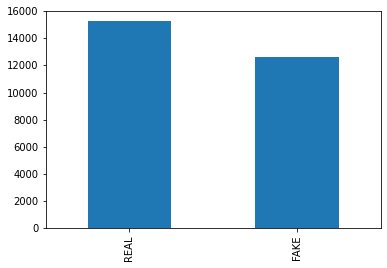

In [ ]:
df['Label'].value_counts().plot(kind = 'bar')

In [ ]:
df['headline_length'] = df['Headline'].str.len()
df['body_length'] = df['Body'].str.len()

In [ ]:
df.describe()

,headline_length,body_length
count,27356.000000,27865.000000
mean,71.017839,4429.890903
std,23.373336,4854.862554
min,1.000000,10.000000
25%,56.000000,1589.000000
50%,71.000000,3348.000000
75%,85.000000,6106.000000
max,653.000000,142961.000000


In [ ]:
df["Text"] = df["Headline"].map(str) + df["Body"]

In [ ]:
#Confusion Matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
#Generating the POS tags for all the articles and adding a new column by replacing text with their POS tags
nlp = spacy.load('en_core_web_sm')
df['Text_pos'] = [' '.join([token.pos_ for token in nlp(text)]) for text in df['Text']]

In [ ]:
#Getting the score of semantic categories generated by Empath of each article and generating a tfidf vector of the unigrams 
lexicon = Empath()
semantic = [np.asarray([value for value in lexicon.analyze(article, 
                                                                 normalize = False).values()])
                  for article in df['Text']]

In [ ]:
categories = [key for key in lexicon.analyze("").keys()]
print(categories)

['help', 'office', 'dance', 'money', 'wedding', 'domestic_work', 'sleep', 'medical_emergency', 'cold', 'hate', 'cheerfulness', 'aggression', 'occupation', 'envy', 'anticipation', 'family', 'vacation', 'crime', 'attractive', 'masculine', 'prison', 'health', 'pride', 'dispute', 'nervousness', 'government', 'weakness', 'horror', 'swearing_terms', 'leisure', 'suffering', 'royalty', 'wealthy', 'tourism', 'furniture', 'school', 'magic', 'beach', 'journalism', 'morning', 'banking', 'social_media', 'exercise', 'night', 'kill', 'blue_collar_job', 'art', 'ridicule', 'play', 'computer', 'college', 'optimism', 'stealing', 'real_estate', 'home', 'divine', 'sexual', 'fear', 'irritability', 'superhero', 'business', 'driving', 'pet', 'childish', 'cooking', 'exasperation', 'religion', 'hipster', 'internet', 'surprise', 'reading', 'worship', 'leader', 'independence', 'movement', 'body', 'noise', 'eating', 'medieval', 'zest', 'confusion', 'water', 'sports', 'death', 'healing', 'legend', 'heroic', 'celebr

In [ ]:
#TF-IDF vector by taking the score for a semantic class as its frequency.
df['Semantics'] = [" ".join(categories[j] for j in range(len(semantic[0])) for k in range(int(semantic[i][j]))) \
                  for i in range(df.shape[0])]

In [ ]:
y = df['Label'].astype('str')
X_train, X_test, y_train, y_test = train_test_split(df,y, test_size=0.2)
X_train.head()

,Headline,Body,Label,headline_length,body_length,Text,Text_pos,Semantics
17177,Так кто же в итоге создал международную коалиц...,Страна: Ирак Как отмечает в своей новой статье...,FAKE,89.0,1220,Так кто же в итоге создал международную коалиц...,PROPN NOUN PROPN PROPN PROPN PROPN PROPN PROPN...,
4623,Mothers’ Diets Have Biggest Influence On Child...,in: General Health Every once in a great while...,FAKE,80.0,3471,Mothers’ Diets Have Biggest Influence On Child...,NOUN PART NOUN AUX ADJ NOUN ADP NOUN VERB PROP...,help office money money wedding domestic_work ...
27401,The next battle over same-sex marriage,(CNN) The battle over same-sex marriage may ha...,REAL,38.0,5719,The next battle over same-sex marriage(CNN) Th...,DET ADJ NOUN ADP ADJ PUNCT NOUN NOUN PUNCT DET...,help help office office office money money mon...
2790,GOVERNMENT HIDING UNPRECEDENTED TB INFECTION R...,Home › HEALTH › GOVERNMENT HIDING UNPRECEDENTE...,FAKE,75.0,4364,GOVERNMENT HIDING UNPRECEDENTED TB INFECTION R...,NOUN VERB ADJ NOUN NOUN NOUN ADP PROPN X PROPN...,help help office office office office office d...
6740,Egyptian kangaroo court confirms 20-year-priso...,(7 fans) - Advertisement - Amid mounting anger...,FAKE,65.0,4617,Egyptian kangaroo court confirms 20-year-priso...,ADJ PROPN NOUN VERB NUM PUNCT NOUN NOUN ADP AD...,help help money money money money money money ...


In [ ]:
def preprocess(dataset):
    
    #Tf-idf Bigrams
    #Initialize the `tfidf_vectorizer`
    tfidf_text_vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (2,2), max_features = 20000)
    # Fit and transform the `Text` data
    tfidf_text = tfidf_text_vectorizer.fit_transform(dataset['Text'].astype('str'))
    
    #POS
    #Initialize the `tfidf_vectorizer` 
    tfidf_pos_vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (2,2)) 
    # Fit and transform the training data 
    tfidf_pos = tfidf_pos_vectorizer.fit_transform(dataset['Text_pos'].astype('str'))
    
    #Semantics
    #Initialize the `tfidf_vectorizer` 
    tfidf_sem_vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (1,1)) 
    # Fit and transform the training data 
    tfidf_sem = tfidf_sem_vectorizer.fit_transform(dataset['Semantics'].astype('str'))
    
    #Giving weights to each of the 3 feature vectors generated
    big_w = 0.35 * 3
    synt_w = 0.5 * 3
    sem_w = 0.15 * 3
    
    tfidf_text = big_w*tfidf_text
    tfidf_pos = synt_w*tfidf_pos
    tfidf_sem = sem_w*tfidf_sem
    
    print(tfidf_text.shape)
    print(tfidf_pos.shape)
    print(tfidf_sem.shape)
    diff_n_rows = tfidf_pos.shape[0] - tfidf_text.shape[0]
    Xb = sp.vstack((tfidf_text, sp.csr_matrix((diff_n_rows, tfidf_text.shape[1])))) 
    #where diff_n_rows is the difference of the number of rows between Xa and Xb
    stack = sp.hstack((tfidf_pos, Xb))
    
    diff_rows = stack.shape[0] - tfidf_sem.shape[0]
    Xb_new = sp.vstack((tfidf_sem, sp.csr_matrix((diff_rows, tfidf_sem.shape[1])))) 
    #where diff_n_rows is the difference of the number of rows between Xa and Xb
    
    return sp.hstack((stack, Xb_new))

In [ ]:
x_train = preprocess(X_train)
x_test = preprocess(X_test)

(22289, 20000)
(22289, 256)
(22289, 193)
(5573, 20000)
(5573, 256)
(5573, 193)


In [ ]:
model = RandomForestClassifier()
#type(x_train.tolist())
model.fit(x_train, y_train)
pickle.dump(model, open('bi_pos_sem_rfc', 'wb'))


In [ ]:
pred = model.predict(x_test)
score = metrics.accuracy_score(y_test, pred)
print("Accuracy with Gradient Bossting Classifier:   %0.3f" % score)

Accuracy with Gradient Bossting Classifier:   0.862


Confusion matrix


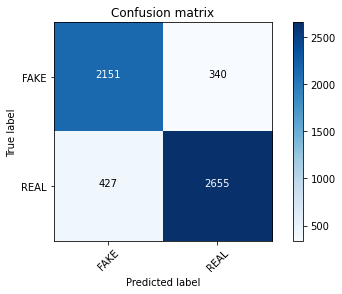

In [ ]:
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [ ]:
#Datasets 
#https://www.kaggle.com/mrisdal/fake-news/ 
#https://www.kaggle.com/jruvika/fake-news-detection/ 
#https://drive.google.com/file/d/1KYr2U2hrHVR4-1LFlg6igGuuT41To75L/view?usp=sharing 


In [ ]:
def preprocess(text, text_pos, semantics):

    #Tf-idf Bigrams
    #Initialize the `tfidf_vectorizer`
    tfidf_text_vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (2,2), max_features = 20000)
    # Fit and transform the `Text` data
    tfidf_text = tfidf_text_vectorizer.fit_transform([text])
    
    #POS
    #Initialize the `tfidf_vectorizer` 
    tfidf_pos_vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (2,2)) 
    # Fit and transform the training data 
    tfidf_pos = tfidf_pos_vectorizer.fit_transform([text_pos])
    
    #Semantics
    #Initialize the `tfidf_vectorizer` 
    tfidf_sem_vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (1,1)) 
    # Fit and transform the training data 
    tfidf_sem = tfidf_sem_vectorizer.fit_transform([semantics])
    
    #Giving weights to each of the 3 feature vectors generated
    big_w = 0.35 * 3
    synt_w = 0.5 * 3
    sem_w = 0.15 * 3
    
    tfidf_text = big_w*tfidf_text
    tfidf_pos = synt_w*tfidf_pos
    tfidf_sem = sem_w*tfidf_sem
    
    diff_n_rows = tfidf_pos.shape[0] - tfidf_text.shape[0]
    Xb = sp.vstack((tfidf_text, sp.csr_matrix((diff_n_rows, tfidf_text.shape[1])))) 
    #where diff_n_rows is the difference of the number of rows between Xa and Xb
    stack = sp.hstack((tfidf_pos, Xb))
    
    diff_rows = stack.shape[0] - tfidf_sem.shape[0]
    Xb_new = sp.vstack((tfidf_sem, sp.csr_matrix((diff_rows, tfidf_sem.shape[1])))) 
    #where diff_n_rows is the difference of the number of rows between Xa and Xb
    
    return sp.hstack((stack, Xb_new))

In [ ]:
test_sample = df.sample(1)[["Headline","Body","Label"]]
headline = str(test_sample["Headline"].values[0])
body = str(test_sample["Body"].values[0])
label = str(test_sample["Label"].values[0])
print(headline)
print(body)

Mets Said to Re-Sign Yoenis Cespedes for Four Years, $110 Million - The New York Times
From the onset of the   the Mets made it clear that their biggest desire was to retain Yoenis Cespedes, the   outfielder who helped transform them into a World Series contender in 2015 and a playoff team in 2016. They knew that his powerful   bat perfectly complemented their lineup and that, as their best   player, he offered them their best chance at competing for a title. On Tuesday, for the second   in a row, the Mets agreed to a deal with Cespedes, this time to the largest   contract they have offered any player in Sandy Alderson’s tenure as general manager: four years and $110 million, according to three people directly involved with the deal who were not authorized to speak about it publicly. The contract, which was still being completed on Tuesday, was contingent on a physical exam, which could be conducted as soon as Wednesday. The deal also included a full   clause, one of the people involve

In [ ]:
text = headline + body
nlp = spacy.load('en_core_web_sm')
text_pos = ' '.join([token.pos_ for token in nlp(text)])
lexicon = Empath()
semantic_arr = np.asarray([value for value in lexicon.analyze(text,normalize = False).values()])
categories = [key for key in lexicon.analyze("").keys()]
semantics = " ".join(categories[j] for j in range(len(semantic_arr)))
x = sp.csr_matrix(preprocess(text,text_pos, semantics),(1,20449))
x_pred = model.predict(x)

In [ ]:
print(x_pred[0])
print(label)

FAKE
REAL
